#**ChatBOT**

## Objective
---
*Chatbots are versatile tools that can be used for a wide range of applications, and the choice of technology depends on the specific use case. The integration of AI technologies, like NLP and ML, can significantly enhance a chatbot's ability to understand and respond to user queries effectively.*

## Aim
---
*We are attempting to build a chatbot completely from the ground up, employing a TRANSFORMER model.*

In [ ]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

## Loading and cleaning Dialogs dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv('/content/drive/MyDrive/ChatBot/dialogs_expanded.csv',encoding='latin-1')
dataset = df[['question','answer']]
dataset.head()

Mounted at /content/drive


,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.


## Dividing into TWO, train/validation

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(dataset, test_size=0.2, random_state=4)

In [ ]:
vocab_ans = list(set(" ".join(train['answer'].values).split()))
vocab_ques = list(set(" ".join(train['question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:69033,69156


## Using tfds SubwordTextEncoder, it will create tokens

**example Multiplication -> Multi, pli, cat, i, on**

**Advantages:**
1. Reduces vocab size => faster learning
2. Reduces chances of missing word in test data

In [ ]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['answer'], target_vocab_size=2**17)

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['question'], target_vocab_size=2**17)

In [ ]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:43958
tokenizer_a:44082


**Examples of subword tokenization in action!**

In [ ]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [43895, 43936, 3495, 12064, 5439, 3495, 43940]
The original string: Encoder decoder
43895---->E
43936---->n
3495---->code
12064---->r 
5439---->de
3495---->code
43940---->r
Tokenized string is [43771, 43812, 3050, 12091, 30962, 43816]
The original string: Encoder decoder
43771---->E
43812---->n
3050---->code
12091---->r 
30962---->decode
43816---->r


In [ ]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [ ]:
print(train['question'].values[0],"\n",train['answer'].values[0])
question, answer = tf_encode(train['question'].values[0],train['answer'].values[0])
print(question)
print(answer)

And the fifty's all gone, huh? Who's the ten for? 
 The Websters.
tf.Tensor(
[43958    69     5  1383 43741     6    60   630     1   318    35   342
 43741     6     5   590   275 43765 43959], shape=(19,), dtype=int64)
tf.Tensor([44082    54 18800 43872 44083], shape=(5,), dtype=int64)


## Creating train_dataset/test_dataset object from Dataframe + padding

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [ ]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 28), dtype=int64, numpy=
array([[43958,   284,    34, ...,     0,     0,     0],
       [43958,  2565,  1327, ...,     0,     0,     0],
       [43958,   103, 43741, ...,     0,     0,     0],
       ...,
       [43958,    12,    42, ...,     0,     0,     0],
       [43958,   171,  1379, ...,     0,     0,     0],
       [43958,   713,    15, ...,     0,     0,     0]])>

# **Positional encoding function where 'i' -> embedding dimn index, 'pos' -> word index in a sentence**

**PE(pos,2i)=sin(pos/10000^(2i/dmodel))**

**PE(pos,2i+1)=cos(pos/10000^(2i/dmodel))**

(1, 50, 512)


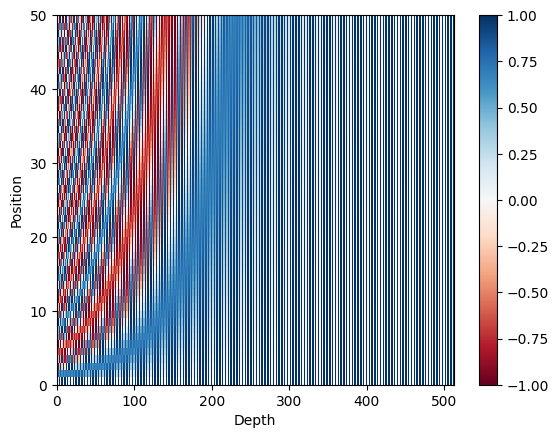

In [ ]:
import matplotlib.pyplot as plt
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# **1. Pad Masking**
**Making all the padded tokens, self attention/attention calculation of a word with those paddings will be ignored**

* Here output dimn -> (batch_size, 1, 1, seq_len)
* for each 8 attention heads, for each query word it will be multiplied, thats why creating 1, 1 in the middle

In [ ]:
# Masking

'''Mask all the pad tokens in the batch of sequence.
It ensures that the model does not treat padding as the input.
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

# **2. Looakahead mask**
for the first word, its self attention calculation with be ignored with proceeding words i.e. second, third word and so on


In [ ]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence.
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# **3. Self Attention and Multi-Head Attention**



<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mstyle mathsize="1.44em">
    <mrow data-mjx-texclass="ORD">
      <mi>P</mi>
      <msub>
        <mi>E</mi>
        <mrow data-mjx-texclass="ORD">
          <mo stretchy="false">(</mo>
          <mi>p</mi>
          <mi>o</mi>
          <mi>s</mi>
          <mo>,</mo>
          <mn>2</mn>
          <mi>i</mi>
          <mo>+</mo>
          <mn>1</mn>
          <mo stretchy="false">)</mo>
        </mrow>
      </msub>
      <mo>=</mo>
      <mi>c</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mo stretchy="false">(</mo>
      <mi>p</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msup>
        <mn>10000</mn>
        <mrow data-mjx-texclass="ORD">
          <mn>2</mn>
          <mi>i</mi>
          <mrow data-mjx-texclass="ORD">
            <mo>/</mo>
          </mrow>
          <msub>
            <mi>d</mi>
            <mrow data-mjx-texclass="ORD">
              <mi>m</mi>
              <mi>o</mi>
              <mi>d</mi>
              <mi>e</mi>
              <mi>l</mi>
            </mrow>
          </msub>
        </mrow>
      </msup>
      <mo stretchy="false">)</mo>
    </mrow>
  </mstyle>
</math>